### Load Modules

In [67]:
import seaborn as sns
from typing import Union
from sklearn.decomposition import non_negative_factorization
import numpy as np
import scanpy as sc
from pathlib import Path
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from tqdm import tqdm
import functools
from anndata import AnnData
import pandas as pd

### Helper Functions

In [68]:
def non_negative_factorization_reimplementation(
        X: np.array, 
        W: Union[None, np.array]=None, 
        H: Union[None, np.array]=None, 
        n_components: Union[None, int]=None, 
        update_H: bool=True,
        max_iter: int=200
) -> tuple[np.array, np.array, int]:

    if n_components is None:
        if H is not None:
            n_components = H.shape[0]
        else:
            n_components = min(X.shape)
    if W is None:
        W = np.ones((X.shape[0], n_components))
    if H is None:
        H = np.ones((n_components, X.shape[1]))
    
    for _ in tqdm(range(max_iter)):
        W = (W.T * (H @ X.T) / (H @ H.T @ W.T + 1e-9)).T
        if update_H:
            H = (H * (W.T @ X) / (W.T @ W @ H + 1e-9))
    return W, H, max_iter

def cosine_similarity_rows(A: np.array, B: np.array) -> np.array:
    norms_A = np.linalg.norm(A, axis=1)
    norms_B = np.linalg.norm(B, axis=1)
    dot_products = np.einsum('ij,ij->i', A, B)
    return dot_products / (norms_A * norms_B)

def create_folders(base_path: str, structure: dict, current_path: Union[str, Path] = None) -> None:
    if current_path is None:
        current_path = Path(base_path)
    Path(current_path).mkdir(exist_ok=True)
    for key, value in structure.items():
        new_path = current_path / str(key)
        if isinstance(value, dict):
            Path(new_path).mkdir(exist_ok=True)
            create_folders(base_path, value, new_path)

def nmf_transfer_basic(adata_query: AnnData, adata_reference: AnnData, n_components: int, nmf_func: callable) -> dict:
    shared_genes_mask_reference = np.isin(adata_reference.var_names, adata_query.var_names)
    shared_genes = adata_reference[:, shared_genes_mask_reference].var_names
    shared_genes_mask_query = np.isin(adata_query.var_names, adata_reference.var_names)
    adata_query_array = adata_query.X.toarray().copy()
    # NMF run 1
    W_init, H_init, _ = nmf_func(adata_reference.X.toarray(), n_components=n_components)
    # NMF run 2
    W, H, _ = nmf_func(adata_query[:, shared_genes].X.toarray(), H=H_init[:, shared_genes_mask_reference], update_H=False)
    return {
        "adata_query_array": adata_query[:, shared_genes].X.toarray().copy(),
        "adata_reference_array": adata_reference.X.toarray().copy(),
        "shared_genes_mask_query": shared_genes_mask_query,
        "shared_genes_mask_reference": shared_genes_mask_reference,
        "W_init": W_init,
        "H_init": H_init,
        "W": W,
        "H": H,
    }

def nmf_transfer_masked(adata_query: AnnData, adata_reference: AnnData, n_components: int, nmf_func: callable) -> dict:
    shared_genes_mask_reference = np.isin(adata_reference.var_names, adata_query.var_names)
    shared_genes = adata_reference[:, shared_genes_mask_reference].var_names
    shared_genes_mask_query = np.isin(adata_query.var_names, adata_reference.var_names)
    adata_query_array = adata_query.X.toarray().copy()
    # NMF run 1
    W_init, H_init, _ = nmf_func(adata_reference[:, shared_genes_mask_reference].X.toarray().copy(), n_components=n_components)
    V = functools.reduce(lambda a, b: np.hstack([a,b]),[(nmf_func(adata_query[:, shared_genes].X.toarray().copy()[:, gene_mask], H=H_init[:, gene_mask], update_H=False))[0] @ H_init[:, ~gene_mask] for gene_mask in ~np.eye(len(shared_genes), dtype=bool)])
    return {
        "adata_query_array": adata_query[:, shared_genes].X.toarray().copy(),
        "adata_reference_array": adata_reference.X.toarray().copy(),
        "shared_genes_mask_query": shared_genes_mask_query,
        "shared_genes_mask_reference": shared_genes_mask_reference,
        "W_init": W_init,
        "H_init": H_init,
        "V": V,
    }


def benchmark_reconstruction(count_matrix: np.array, count_matrix_reconstructed: np.array) -> None:
    log_original = np.log1p(count_matrix)
    log_reconstructed = np.log1p(count_matrix_reconstructed)

    row_means_original = count_matrix.mean(axis=1)
    row_means_reconstructed = count_matrix_reconstructed.mean(axis=1)
    col_means_original = count_matrix.mean(axis=0)
    col_means_reconstructed = count_matrix_reconstructed.mean(axis=0)

    fig, axes = plt.subplots(3, 2, figsize=(6, 8))

    sns.heatmap(log_original, ax=axes[0, 0], cmap="magma", cbar=True)
    axes[0, 0].set_title("Log Transformed \n Original Count Matrix")

    sns.heatmap(log_reconstructed, ax=axes[0, 1], cmap="magma", cbar=True)
    axes[0, 1].set_title("Log Transformed \n Reconstructed Count Matrix")

    pearson_row, _ = pearsonr(row_means_original, row_means_reconstructed)
    axes[1, 0].scatter(row_means_original, row_means_reconstructed, alpha=0.5, color="black")
    axes[1, 0].plot([row_means_original.min(), row_means_original.max()], 
                    [row_means_original.min(), row_means_original.max()], 
                    linestyle="dashed", color="red")
    axes[1, 0].set_xlabel("Cell Mean (Original)")
    axes[1, 0].set_ylabel("Cell Mean (Reconstructed)")
    axes[1, 0].set_title("Cell-wise Mean Comparison")
    axes[1, 0].text(0.05, 0.9, f"Pearson r = {pearson_row:.2f}", 
                    transform=axes[1, 0].transAxes, fontsize=10, color="blue")
    
    pearson_col, _ = pearsonr(col_means_original, col_means_reconstructed)
    axes[1, 1].scatter(col_means_original, col_means_reconstructed, alpha=0.5, color="black")
    axes[1, 1].plot([col_means_original.min(), col_means_original.max()], 
                    [col_means_original.min(), col_means_original.max()], 
                    linestyle="dashed", color="red")
    axes[1, 1].set_xlabel("Gene Mean (Original)")
    axes[1, 1].set_ylabel("Gene Mean (Reconstructed)")
    axes[1, 1].set_title("Gene-wise Mean Comparison")
    axes[1, 1].text(0.05, 0.9, f"Pearson r = {pearson_col:.2f}", 
                    transform=axes[1, 1].transAxes, fontsize=10, color="blue")

    sns.violinplot(cosine_similarity_rows(count_matrix, count_matrix_reconstructed), ax=axes[2, 0])
    axes[2, 0].set_title("Cosine Similarity Cells")
    sns.violinplot(cosine_similarity_rows(count_matrix.T, count_matrix_reconstructed.T), ax=axes[2, 1])
    axes[2, 1].set_title("Cosine Similarity Genes")

    sns.despine()
    plt.tight_layout()
    plt.show()

In [69]:
create_folders(
    str(Path.cwd()),
    {
        "data": {
            "inputQuery": {},
            "inputRef": {},
            "nico_out": {},
        }
    }
)

### Load Data

In [70]:
celltype = "Stem/TA"
adata_sp = (lambda x: x[x.obs["nico_ct"] == celltype].copy())(sc.read_h5ad(Path.cwd() / "data" / "nico_out" / "nico_celltype_annotation.h5ad"))
#adata_sp = sc.read_h5ad(Path.cwd() / "data" / "nico_out" / "nico_celltype_annotation.h5ad")
adata_sc = (lambda x: x[x.obs["cluster"] == celltype].copy())(sc.read_h5ad(Path.cwd() / "data" / "inputRef" / "input_ref.h5ad"))
#adata_sc = sc.read_h5ad(Path.cwd() / "data" / "inputRef" / "input_ref.h5ad")
#sc.pp.filter_genes(adata_sp, min_counts=50)
#sc.pp.filter_genes(adata_sc, min_counts=50)
sc.pp.filter_genes(adata_sp, min_counts=50)
sc.pp.filter_genes(adata_sc, min_counts=50)
shared_genes_mask_sc = np.isin(adata_sc.var_names, adata_sp.var_names)
shared_genes_mask_sp = np.isin(adata_sp.var_names, adata_sc.var_names)
shared_genes = adata_sc[:, shared_genes_mask_sc].var_names
print(f"{len(shared_genes)=}")

len(shared_genes)=47


In [71]:
sc.pp.normalize_total(adata_sc)
sc.pp.log1p(adata_sc)
sc.pp.normalize_total(adata_sp)
sc.pp.log1p(adata_sp)

In [72]:
n_components = 20

res_sklearn = nmf_transfer_basic(
    adata_query=adata_sp,
    adata_reference=adata_sc,
    n_components=n_components,
    nmf_func=non_negative_factorization
)

res_reimplementation = nmf_transfer_basic(
    adata_query=adata_sp,
    adata_reference=adata_sc,
    n_components=n_components,
    nmf_func=functools.partial(non_negative_factorization_reimplementation, max_iter=500)
)

/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
100%|██████████| 500/500 [00:00<00:00, 17535.30it/s]


## NMF

### Baseline Reconstruction Quality of Spatial Data

n_components=20
Baseline reconstruction spatial data using sklearns NMF implementation


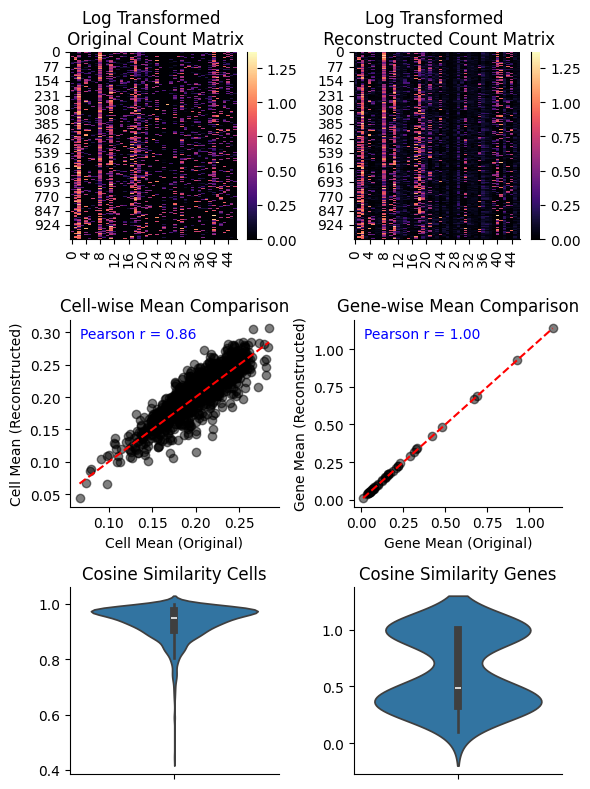

Baseline Reconstruction spatial data using manual implementation of NMF


100%|██████████| 500/500 [00:00<00:00, 6377.15it/s]


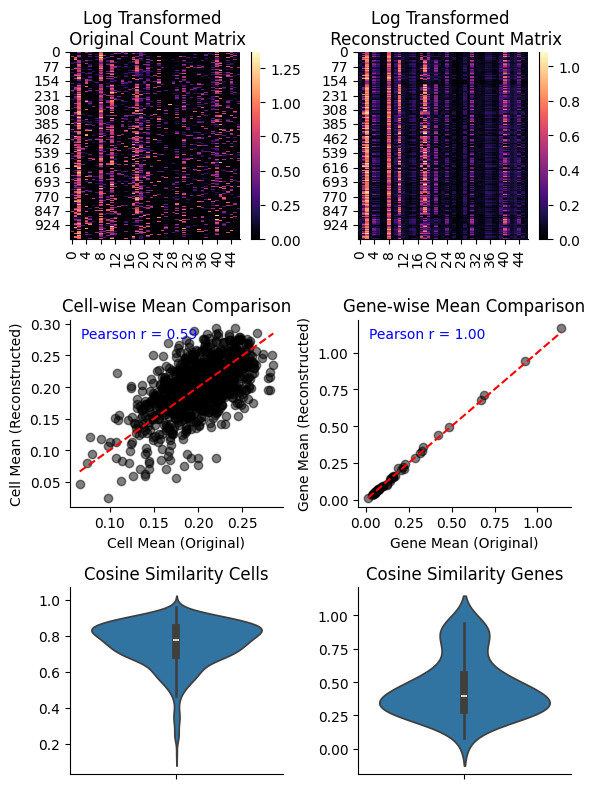

In [73]:
print(f"{n_components=}")
print("Baseline reconstruction spatial data using sklearns NMF implementation")
(lambda X, nmf_func: benchmark_reconstruction(
    X, 
    (lambda W, H, _: W @ H)(
        *nmf_func(X)
    )
))(
    adata_sp[:, shared_genes].X.toarray(),
    functools.partial(non_negative_factorization, n_components=n_components)
)
print("Baseline Reconstruction spatial data using manual implementation of NMF")
(lambda X, nmf_func: benchmark_reconstruction(
    X, 
    (lambda W, H, _: W @ H)(
        *nmf_func(X)
    )
))(
    adata_sp[:, shared_genes].X.toarray(),
    functools.partial(non_negative_factorization_reimplementation, n_components=n_components, max_iter=500)
)

### Reconstruction Quality of single cell reference data

n_components=20
Baseline reconstruction single cell data using sklearns NMF implementation


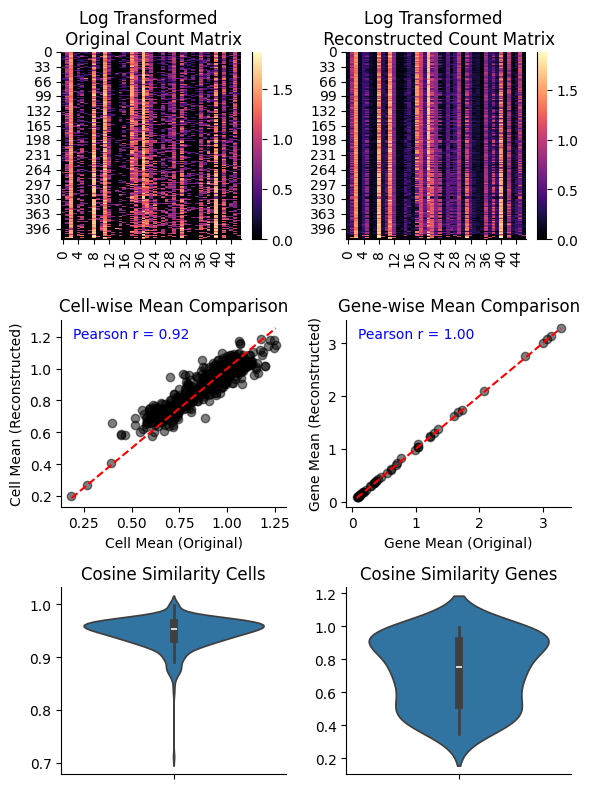

Baseline Reconstruction single cell data using manual implementation of NMF


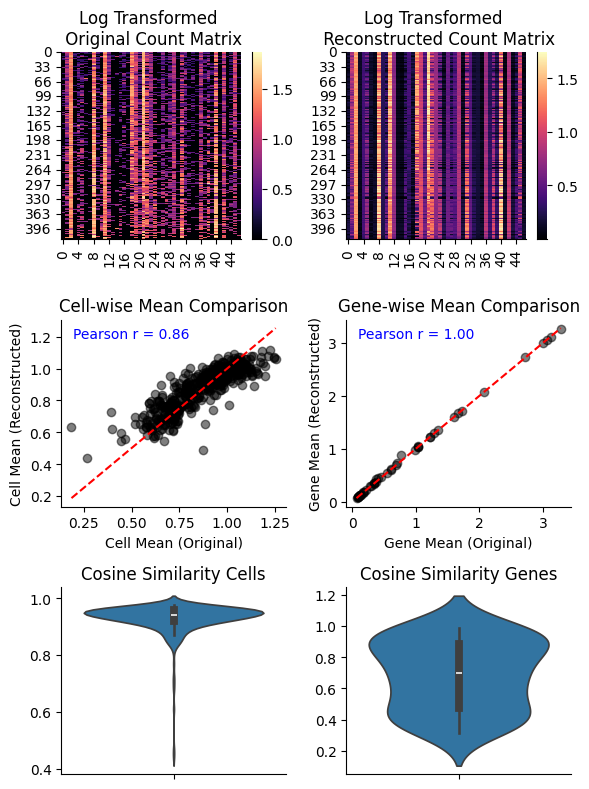

In [74]:
print(f"{n_components=}")
print("Baseline reconstruction single cell data using sklearns NMF implementation")
(lambda res_dict:
 benchmark_reconstruction(
     res_dict["adata_reference_array"][:, res_dict["shared_genes_mask_reference"]],
     res_dict["W_init"] @ res_dict["H_init"][:, res_dict["shared_genes_mask_reference"]]
 ))(
     res_sklearn
 )

print("Baseline Reconstruction single cell data using manual implementation of NMF")
(lambda res_dict:
 benchmark_reconstruction(
     res_dict["adata_reference_array"][:, res_dict["shared_genes_mask_reference"]],
     res_dict["W_init"] @ res_dict["H_init"][:, res_dict["shared_genes_mask_reference"]]
 ))(
     res_reimplementation
 )

### Reconstruction Quality of spatial data with H-Matrix (gene by factor matrix) initialized and fixed from previous single cell NMF

n_components=20
Spatial data reconstruction with fixed H-Matrix (factor x gene) from previous single cell run sklearn implementation


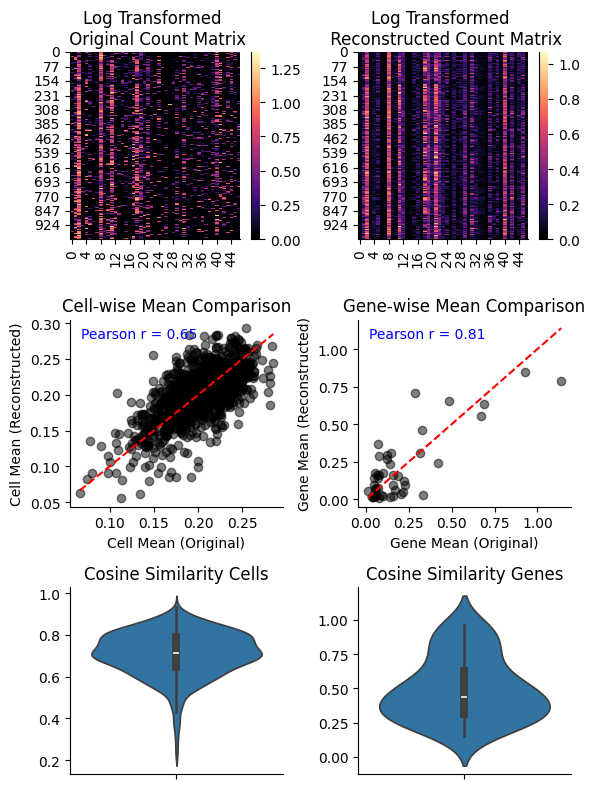

Spatial data reconstruction with fixed H-Matrix (factor x gene) from previous single cell run using nmf reimplementation


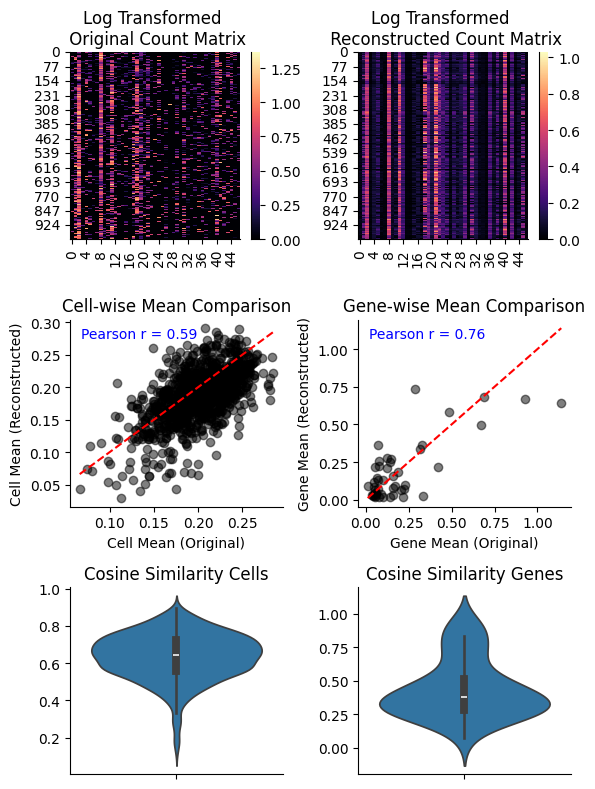

In [75]:
print(f"{n_components=}")
print("Spatial data reconstruction with fixed H-Matrix (factor x gene) from previous single cell run sklearn implementation")
(lambda res_dict:
 benchmark_reconstruction(
     res_dict["adata_query_array"],
     res_dict["W"] @ res_dict["H"]
 ))(
     res_sklearn
 )
print("Spatial data reconstruction with fixed H-Matrix (factor x gene) from previous single cell run using nmf reimplementation")
(lambda res_dict:
 benchmark_reconstruction(
     res_dict["adata_query_array"],
     res_dict["W"] @ res_dict["H"]
 ))(
     res_reimplementation
 )

### Reconstruction Quality of spatial data iteratively with individual masked genes with H-Matrix (gene by factor matrix) initialized and fixed from previous single cell NMF 

In [76]:
res_masked_1 = nmf_transfer_masked(
    adata_sp, adata_sc, n_components=n_components, nmf_func=non_negative_factorization
)

res_masked_2 = nmf_transfer_masked(
    adata_sp, adata_sc, n_components=n_components, nmf_func=non_negative_factorization_reimplementation
)

/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
100%|██████████| 200/200 [00:00<00:00, 18296.56it/s]


n_components=20
Spatial data reconstruction with fixed H-Matrix (factor x gene) from previous single cell run using sklearn nmf and masked genes


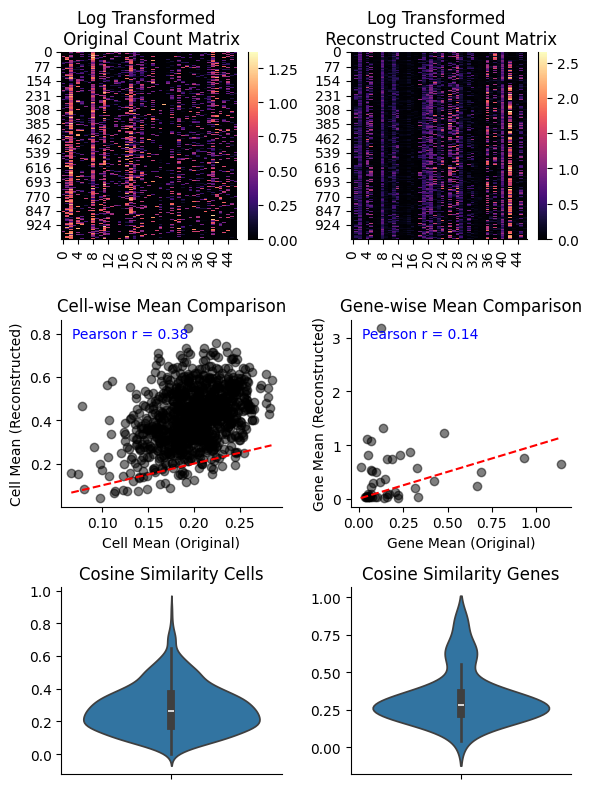

Spatial data reconstruction with fixed H-Matrix (factor x gene) from previous single cell run using nmf reimplementation and masked genes


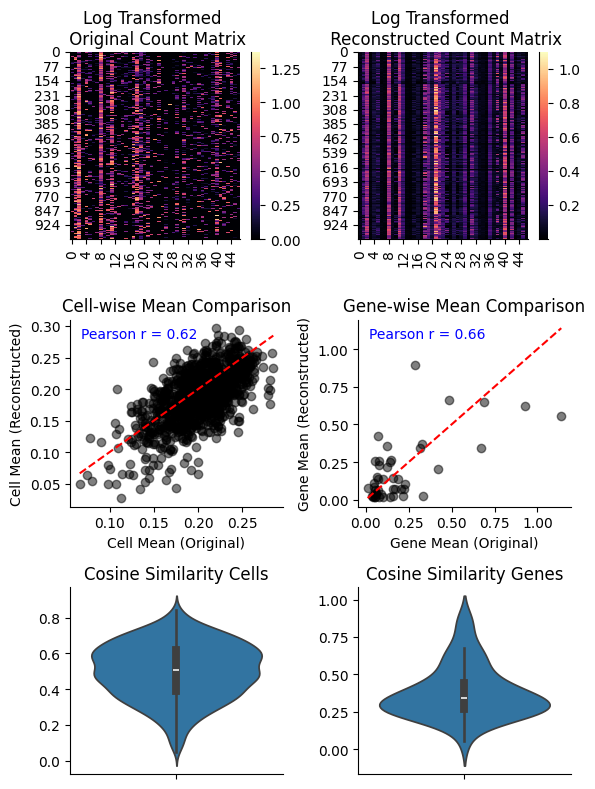

In [77]:
print(f"{n_components=}")
print("Spatial data reconstruction with fixed H-Matrix (factor x gene) from previous single cell run using sklearn nmf and masked genes")
benchmark_reconstruction(
    res_masked_1["adata_query_array"],
    res_masked_1["V"],
)

print("Spatial data reconstruction with fixed H-Matrix (factor x gene) from previous single cell run using nmf reimplementation and masked genes")
benchmark_reconstruction(
    res_masked_2["adata_query_array"],
    res_masked_2["V"],
)

### Randomly Reconstructed Matrix by sampling featurewise

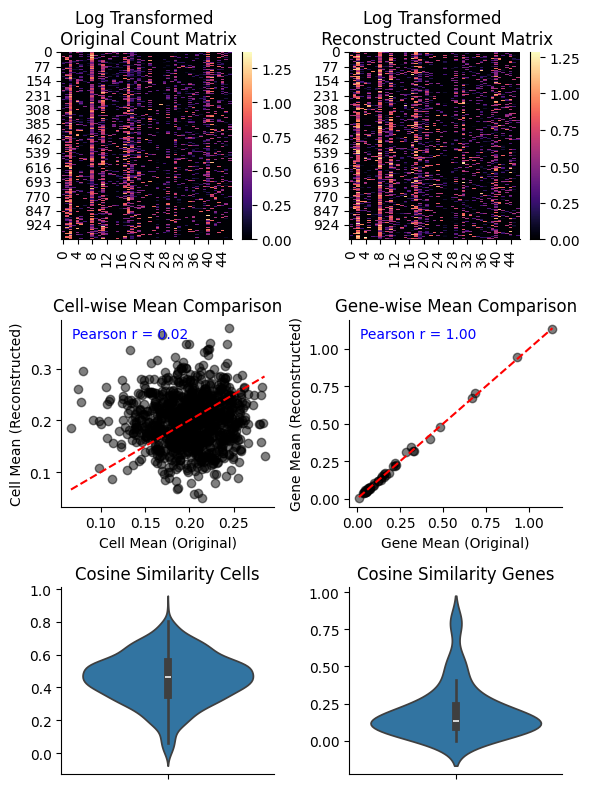

In [78]:
(lambda X:
 benchmark_reconstruction(
     X,
     np.apply_along_axis(lambda vec: np.random.choice(vec, size=len(vec), replace=True), axis=0, arr=X)
 ))(
    adata_sp[:, shared_genes].X.toarray()
    #adata_sc[:, shared_genes_mask_sc].X.toarray()
 )

## Initializing NMF #1 with rank genes of leiden clusters

In [79]:
adata_sc

AnnData object with n_obs × n_vars = 420 × 9990
    obs: 'cluster'
    var: 'n_counts'
    uns: 'log1p'

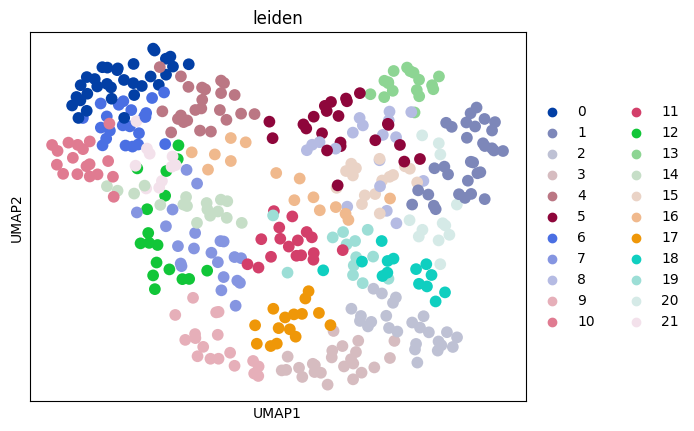

In [80]:
sc.pp.normalize_total(adata_sc)
sc.pp.log1p(adata_sc)

sc.tl.pca(adata_sc)
sc.pp.neighbors(adata_sc)
sc.tl.leiden(adata_sc, resolution=2.9812)
sc.tl.umap(adata_sc)
sc.pl.umap(adata_sc,color='leiden')

In [81]:
sc.tl.rank_genes_groups(adata_sc, 'leiden')

/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:429: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:431: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.1

In [82]:
# W matrix constructed from the rank_genes_groups scores for the number of clusters.
Hinit = (lambda arr: np.where(arr < 0, 0.1, arr))(
    pd.concat(
        [sc.get.rank_genes_groups_df(adata_sc, index).set_index("names")["scores"] for index in list(adata_sc.uns["rank_genes_groups"]["names"].dtype.names)], 
        axis=1
    ).reindex(adata_sc.var.index).values.astype(adata_sc.X.toarray().dtype).T
)
# H matrix constructed from cells belonging to a certain cluster (1 for belonging, 0.1 for not belonging)
Winit = pd.get_dummies(adata_sc.obs["leiden"], dtype=adata_sc.X.toarray().dtype).replace(0, 0.1).values

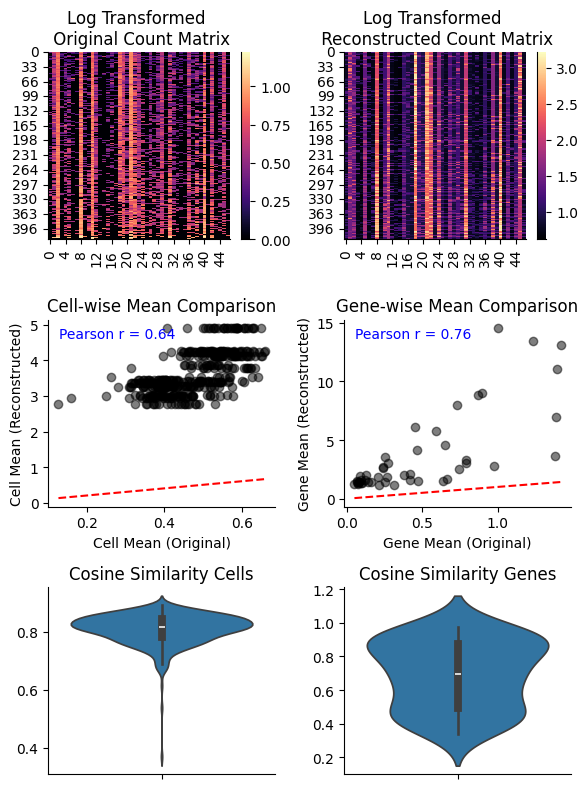

In [83]:
benchmark_reconstruction(adata_sc[:, shared_genes_mask_sc].X.toarray(), Winit @ Hinit[:, shared_genes_mask_sc])

In [84]:
(lambda arr, n: (arr[:n], arr[n:]))(np.random.permutation(np.arange(0, len(shared_genes))), 10)

(array([40, 36,  9, 11,  2, 24,  0, 31, 39, 20]),
 array([30, 42, 43, 32, 45, 28, 19, 17,  4, 29, 23, 33, 41, 18, 35,  3, 34,
        27, 15, 38, 13,  7,  8, 14, 10, 26, 12,  6,  5,  1, 44, 46, 16, 22,
        37, 21, 25]))

In [85]:
W, H, _ = non_negative_factorization_reimplementation(adata_sc[:, shared_genes_mask_sc].X.toarray().copy(), W=Winit, H=Hinit[:, shared_genes_mask_sc])

100%|██████████| 200/200 [00:00<00:00, 17514.58it/s]


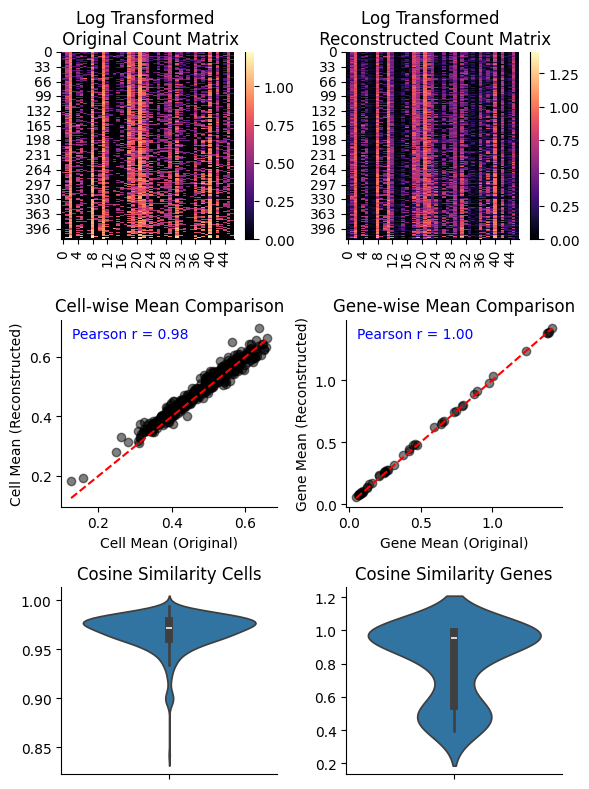

In [86]:

benchmark_reconstruction(adata_sc[:, shared_genes_mask_sc].X.toarray(), W @ H)

In [87]:
(lambda X, nmf_func: benchmark_reconstruction(
    X, 
    (lambda W, H, _: W @ H)(
        *nmf_func(X)
    )
))(
    adata_sc[:, shared_genes_mask_sc].X.toarray(),
    functools.partial(non_negative_factorization_reimplementation, W=Winit, H=Hinit)
)

  0%|          | 0/200 [00:00<?, ?it/s]


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 47 is different from 9990)